In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# **1. Obtención de Datos (10 puntos)**


* Se solicita información de precios de energía mediante una API entre las fechas 2024-03-15 y 2024-04-14.
* La solicitud debe incluir los parámetros start_date y end_date para especificar el rango de fechas.
  Puntos adicionales: Manejo de errores HTTP


In [2]:
 api_url = "https://l2h237eh53.execute-api.us-east-1.amazonaws.com/dev/precios"

In [3]:
 def connect_to_api(start_date='2024-03-15', end_date='2024-04-14'):
    params = {'start_date': start_date,
              'end_date' : end_date}
    
    try:
        response = requests.get(api_url, params=params)

        
        if response.status_code == 200:
            data = response.json()
            data = data['data']
            data = pd.DataFrame(data)
            return data
        else:
            print(f"Error: connect to API {response.status_code}. {response.text}")
            return None
            
    except requests.exceptions.Timeout:
        print("Error: Timeout  trying to connect to the API.")
        
    except requests.exceptions.RequestException as e:
        print(f"Connection error: {e}")

    return None


df = connect_to_api()

In [4]:
df.head()

,2024-03-15,2024-03-16,2024-03-17,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-23,2024-03-24,2024-03-25,...,2024-04-05,2024-04-06,2024-04-07,2024-04-08,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-13,2024-04-14
01:00,551.70,568.32,589.99,595.36,641.97,658.67,713.51,773.68,729.05,787.54,...,836.12,503.36,700.74,830.40,1010.43,967.38,1005.79,1020.02,1020.02,1056.17
02:00,551.70,568.32,568.49,574.36,630.77,658.67,708.51,718.87,729.05,758.54,...,759.37,502.36,671.24,750.51,905.54,967.38,1005.79,1010.02,1008.02,1055.62
03:00,551.70,568.32,568.49,574.36,571.77,641.79,696.51,718.87,717.16,719.54,...,502.12,501.36,610.74,750.51,905.54,504.97,1005.79,1010.02,995.02,1055.62
04:00,497.36,566.12,568.49,574.36,550.77,641.79,696.51,718.87,716.96,719.54,...,502.12,501.36,605.74,750.51,905.54,504.97,1005.79,1010.02,995.02,1055.62
05:00,551.70,566.12,568.49,574.36,550.77,641.79,708.51,718.87,700.96,658.54,...,759.37,501.36,605.74,750.51,905.54,966.97,1005.79,1010.02,995.02,1010.12


* ¿Cuántos días se obtienen de datos?

Se obtienen 30 datos históricos.

In [5]:
df.shape

(24, 30)

# **Procesamiento de los Datos (20 puntos)**

* Los datos se transforman a un DataFrame de Pandas para su posterior análisis.
* Normalización de formato temporal


In [6]:
df = df.reset_index()
df = df.rename(columns={'index': 'hora'})
df = pd.melt(df, id_vars=['hora'], var_name='fecha', value_name='precio')

* Se deben manejar las fechas y horas correctamente, considerando que algunos valores de hora puedan estar mal formateados (por ejemplo, 24:00 en lugar de 00:00). hint: utilizar str.replace & pd.to_datetime

In [7]:
df.hora = df.hora.str.replace('24', '00', regex=True)
df.hora = pd.to_datetime(df.hora, format='%H:%M').dt.strftime("%H:%M")

In [8]:
df.head()

,hora,fecha,precio
0,01:00,2024-03-15,551.70
1,02:00,2024-03-15,551.70
2,03:00,2024-03-15,551.70
3,04:00,2024-03-15,497.36
4,05:00,2024-03-15,551.70


# **3.Tratamiento de Datos Faltantes (30 puntos)**

###  Se deben identificar y gestionar las horas faltantes en el conjunto de datos. Los valores faltantes deben llenarse: 

In [9]:
df.isna().sum()

hora      0
fecha     0
precio    4
dtype: int64

* ¿Cuáles son las horas donde hacen falta valores?

In [10]:
df[df.precio.isna()]

,hora,fecha,precio
566,15:00,2024-04-08,NaN
590,15:00,2024-04-09,NaN
591,16:00,2024-04-09,NaN
592,17:00,2024-04-09,NaN


In [11]:
df[df.precio.isna()]['hora']

566    15:00
590    15:00
591    16:00
592    17:00
Name: hora, dtype: object

* Primero, rellenando los datos faltantes en las horas con el valor anterior más cercano disponible.

In [12]:
df["precio"] = df["precio"].fillna(method="ffill")

/tmp/ipykernel_186851/3281516021.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["precio"] = df["precio"].fillna(method="ffill")


In [13]:
df.isna().sum()

hora      0
fecha     0
precio    0
dtype: int64

* Luego, para los días faltantes, se deben rellenar utilizando el promedio de los 3 días previos y los 3 días posteriores a la fecha faltante.

In [14]:
def fill_missing_with_avg(df):
    for i in range(len(df)):
        if pd.isna(df.loc[i, "precio"]):
            current_date = df.loc[i, "fecha"]
            
            # Se toman los 3 dias previos y los 3 dias posteriores
            prev_days = df[(df["fecha"] < current_date) & (df["fecha"] >= current_date - pd.Timedelta(days=3))]["precio"]
            next_days = df[(df["fecha"] > current_date) & (df["fecha"] <= current_date + pd.Timedelta(days=3))]["precio"]

            avg_price = pd.concat([prev_days, next_days]).mean()

            if not pd.isna(avg_price):
                df.loc[i, "precio"] = avg_price


fill_missing_with_avg(df)

# **4 Cálculos de Promedios (10 puntos)**

* Se debe calcular el promedio diario de precios.

In [15]:
daily_avg = df.groupby("fecha")["precio"].mean().reset_index()

In [16]:
daily_avg

,fecha,precio
0,2024-03-15,557.669167
1,2024-03-16,574.449167
2,2024-03-17,581.365000
3,2024-03-19,617.401667
4,2024-03-20,625.661667
5,2024-03-21,654.168333
6,2024-03-22,707.120417
7,2024-03-23,715.151250
8,2024-03-24,651.767500
9,2024-03-25,735.623333


* Además, calcular un promedio móvil de 7 días de los precios diarios.

In [17]:
last_7_days_avg = daily_avg["precio"].rolling(window=7, min_periods=1).mean()

In [18]:
last_7_days_avg

0     557.669167
1     566.059167
2     571.161111
3     582.721250
4     591.309333
5     601.785833
6     616.833631
7     639.331071
8     650.376548
9     672.413452
10    703.690179
11    746.854940
12    775.011190
13    790.089821
14    795.751369
15    804.286250
16    820.540536
17    848.089464
18    891.566012
19    924.218155
20    947.051905
21    932.579048
22    921.003393
23    930.523393
24    924.660595
25    885.462440
26    878.135714
27    886.911369
28    938.875298
29    996.589583
Name: precio, dtype: float64

# **5 Visualización (15 puntos)**


* Se debe generar una gráfica que compare los promedios diarios con el promedio móvil de 7 días.
* La gráfica debe ser clara, con leyenda y título apropiados.
* Almacenar la gráfica como image.png


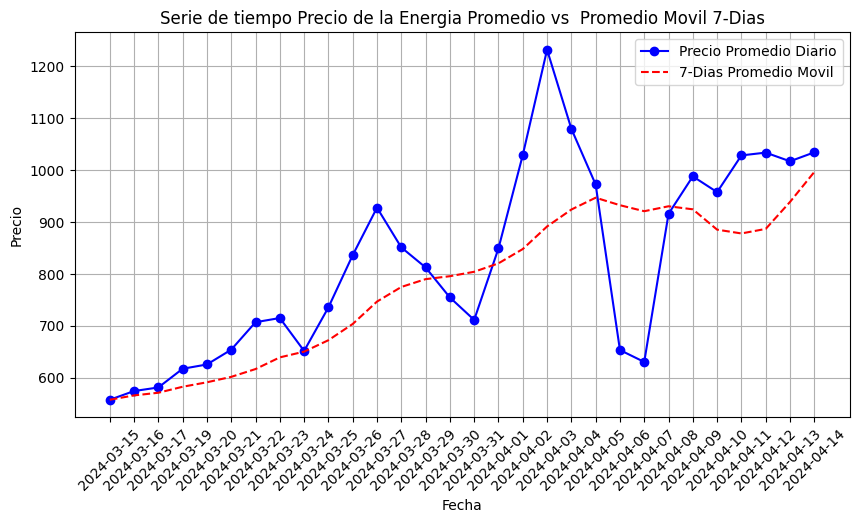

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(daily_avg["fecha"], daily_avg["precio"], marker="o", linestyle="-", label="Precio Promedio Diario", color="blue")
plt.plot(daily_avg["fecha"], last_7_days_avg, linestyle="--", label="7-Dias Promedio Movil", color="red")

# Formatting the plot
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Serie de tiempo Precio de la Energia Promedio vs  Promedio Movil 7-Dias")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.savefig("image.png", dpi=300, bbox_inches="tight")


# Show the plot
plt.show()


* ¿Cuál es el comportamiento del precio para el periodo?


In [20]:
daily_avg.describe()

,precio
count,30.000000
mean,824.596958
std,183.770690
min,557.669167
25%,653.646146
50%,824.504792
75%,984.233021
max,1232.150833


In [21]:
daily_avg[daily_avg.precio < 558]

,fecha,precio
0,2024-03-15,557.669167


In [22]:
daily_avg[daily_avg.precio >= 1232]

,fecha,precio
18,2024-04-03,1232.150833


El comportamiento del precio de la energía para el periodo comprendido entre las fechas 2024-03-15 y 2024-04-14 muestra una tendencia alcista, alcanzando un pico monetario de 1232.150833 el 2024-04-03 y un mínimo histórico de 557.669167 el 2024-03-15.

# **Almacenamiento de Resultados (15 puntos)**

* Almacenar los resultados diarios (promedio diario y promedio móvil de 7 días) en una base de datos SQLite.
* El esquema de la tabla debe incluir las columnas fecha, precio_promedio, precio_7d.


In [23]:
new_df = pd.DataFrame()
new_df['fecha'] = daily_avg.fecha
new_df['precio_promedio'] = daily_avg.precio
new_df['precio_7d'] = last_7_days_avg

In [24]:
new_df.head()

,fecha,precio_promedio,precio_7d
0,2024-03-15,557.669167,557.669167
1,2024-03-16,574.449167,566.059167
2,2024-03-17,581.365000,571.161111
3,2024-03-19,617.401667,582.721250
4,2024-03-20,625.661667,591.309333


In [25]:
conn = sqlite3.connect('precios.db')

In [26]:
new_df.to_sql('PlusenergyTable', conn, if_exists='replace', index=False)

30